<div style="background-color:	#216375 ; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:black"> Generative AI: Portfolio 1, Diffusion Model from scratch</h1>
<b style="color:white"> Julia Boschman, Daan Eising</b>
    </div>

<a name='start'></a>

## Table of contents

1. [H1: Inleiding](#1.0)
    - [&sect;1.1: Imports](#1.1)
2. [H2: Dataset](#2.0)
    - [&sect;2.1: Let op!](#2.1)
    - [&sect;2.2: Aanmaken nieuwe map](#2.2)
    - [&sect;2.3: Inlezen afbeeldingen bestaande map](#2.3)
    - [&sect;2.4: Weergave selectie dataset](#2.4)
3. [H3: Diffusion Model from scratch](#3.0)
    - [&sect;3.1: Aanmaken parameters Diffusion Model](#3.1)
    - [&sect;3.2: Dataset klaarmaken voor training](#3.2)
    - [&sect;3.3: Het model aanroepen](#3.3)
    - [&sect;3.4: Het model trainen](#3.4)
4. [H4: Vergelijken werkelijke data met gegenereerde data](#4.0)
5. [H5: Korte reflectie op resultaten](#5.0)
6. [H6: Literatuurlijst](#6.0)

[Back to the top](#start)
<a name='1.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: Inleiding</strong></h2>
</div>

Voor het eerste portfolio van Generative AI is het de bedoeling om een model uit te kiezen en deze "from scratch" na te bouwen. Dit hebben wij gedaan op basis van deze [paper](https://arxiv.org/pdf/2006.11239) over Diffusion models. We kozen voor dit model omdat wij ons als duo eerder al in een andere paper over diffusion-modellen hebben verdiept. Door voor dit portfolio dit model te kiezen, kunnen we nu zelf proberen een diffusie­model te implementeren.
Het paper legt in detail uit wat de werking en de wiskunde is achter het model en deelt de resultaten van hun invulling van de Denoising Diffusion Probabilistic Models. In dit notebook laten wij zien hoe het main.py bestandje gebruikt kan worden om een Diffusion model te trainen. Verdere code van het model zelf is dan dus ook te vinden in het main.py bestand.

<a name='1.1'></a>
<h3>&sect;1.1: Imports</h3>

Om er voor te zorgen dat alle modules gedownload kunnen worden doen we eerst een pip install voor alle modules die niet geïnstalleerd zijn.

In [1]:
#!pip install tensorflow
#!pip install tqdm

Nu alle ontbrekende modules zijn geïnstalleerd, kunnen we de benodigde modules importeren. Aangezien een deel hiervan al wordt aangeroepen in main.py, is het niet nodig om alles opnieuw in het notebook te importeren. Omdat we dit notebook draaien in Google Colab, hebben we wel extra imports toegevoegd die specifiek daarvoor nodig zijn. Voor de volledigheid en leesbaarheid hebben we hieronder alsnog alle gebruikte modules opgenomen.

In [11]:
import os
import numpy as np
from PIL import Image
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tqdm import tqdm

# Imports voor werking google drive

from google.colab import drive
import shutil

# Import nodig voor het importeren van main.py uit drive
import sys
sys.path.append('/content/drive/MyDrive/portfolio_genai_1') # Dit pad is

from main import *


In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[Back to the top](#start)
<a name='2.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: Dataset</strong></h2>
</div>

Een Diffusion model kan zowel gebruikt worden voor het genereren van tekst als het genereren van afbeeldingen. De paper over Diffusion Models die wij hebben gelezen gebruikt de toepassing van het genereren van afbeeldingen. Om die reden hebben wij er voor gekozen om in dit notebook ook gebruik te maken van afbeeldingen.


De afbeeldingen die wij hebben gekozen om te genereren is de [Barok](https://www.kaggle.com/datasets/steubk/wikiart?select=Baroque) dataset van Kaggle's WikiArt. In de dataset staan afbeeldingen van een hoop verschillende soorten kunst. Denk hier bijvoorbeeld aan abstract expressionisme, modern realisme, impressionisme, pop art en nog een hoop andere soorten kunst. De reden dat wij hebben gekozen voor de Barok dataset is, omdat het ons gaaf leek om nieuwe kunst te genereren van een stijl die nog niet vaak wordt gebruikt in de generatieve AI. Hierdoor zagen wij het als een leuke uitdaging en zal het leuk zijn om een resultaat te zien van een nieuw kunstwerk met een stijl uit de zeventiende en achttiende eeuw.


Om dit notebook zelf te kunnen runnen is het belangrijk om eerst de boven genoemde dataset te downloaden van Kaggle. Dit is gemakkelijk en gratis te doen met een Kaggle account. Hierdoor is het ook mogelijk voor andere mensen om gebruik te maken van onze toepassing.

<a name='2.1'></a>
<h3>&sect;2.1: Let op</h3>

### Let op: Hieronder staan twee codecellen: 2.2 en 2.3.

Codecel 2.2 bevat code om de originele afbeeldingen te resizen naar het gewenste formaat. Dit proces duurt gemiddeld 8 minuten. Zodra dit eenmaal is gedaan, hoeft deze stap niet opnieuw uitgevoerd te worden. Daarom is assert False toegevoegd: dit voorkomt dat de cel per ongeluk wordt uitgevoerd bij “Run all”.
Wil je toch opnieuw resizen, dan kun je de assert handmatig verwijderen.
Codecel 2.3 bevat de code om eerder geresize-de afbeeldingen in te laden vanuit de juiste bestandslocatie.

<a name='2.2'></a>
<h3>&sect;2.2: Aanmaken nieuwe map</h3>

In [ ]:
# Deze code cell niet runnen!
assert False, # Zorgt ervoor dat de code cell faalt voor

IMAGE_DIR = "/content/drive/MyDrive/portfolio_genai_1/Baroque"
SAVE_DIR = "/content/drive/MyDrive/portfolio_genai_1/Processed_Baroque_32"

# Grootte van de afbeeldingen
IMG_SIZE = (32, 32)
os.makedirs(SAVE_DIR, exist_ok=True)

dataset_32 = preprocess_and_save_images(IMAGE_DIR, SAVE_DIR, IMG_SIZE)
print(f"Dataset geladen met vorm: {dataset_32.shape}")

<a name='2.3'></a>
<h3>&sect;2.3: Inlezen afbeeldingen bestaande map</h3>

Voor het inlezen van de afbeeldingen uit een bestaande map.

In [24]:
dataset_32 = load_images_from_folder(SAVE_DIR)

KeyboardInterrupt: 

<a name='2.4'></a>
<h3>&sect;2.4: Weergave selectie dataset</h3>


Hieronder voeren wij de functie show_images uit op de geresize-de dataset en geven aan dat we er 9 willen zien. Door een aantal willekeurige afbeeldingen uit de dataset te tonen, krijgen we een eerste indruk van de data. Zo kunnen we ook controleren of de data het gewenste formaat heeft en om welke stijl afbeeldingen het gaat.


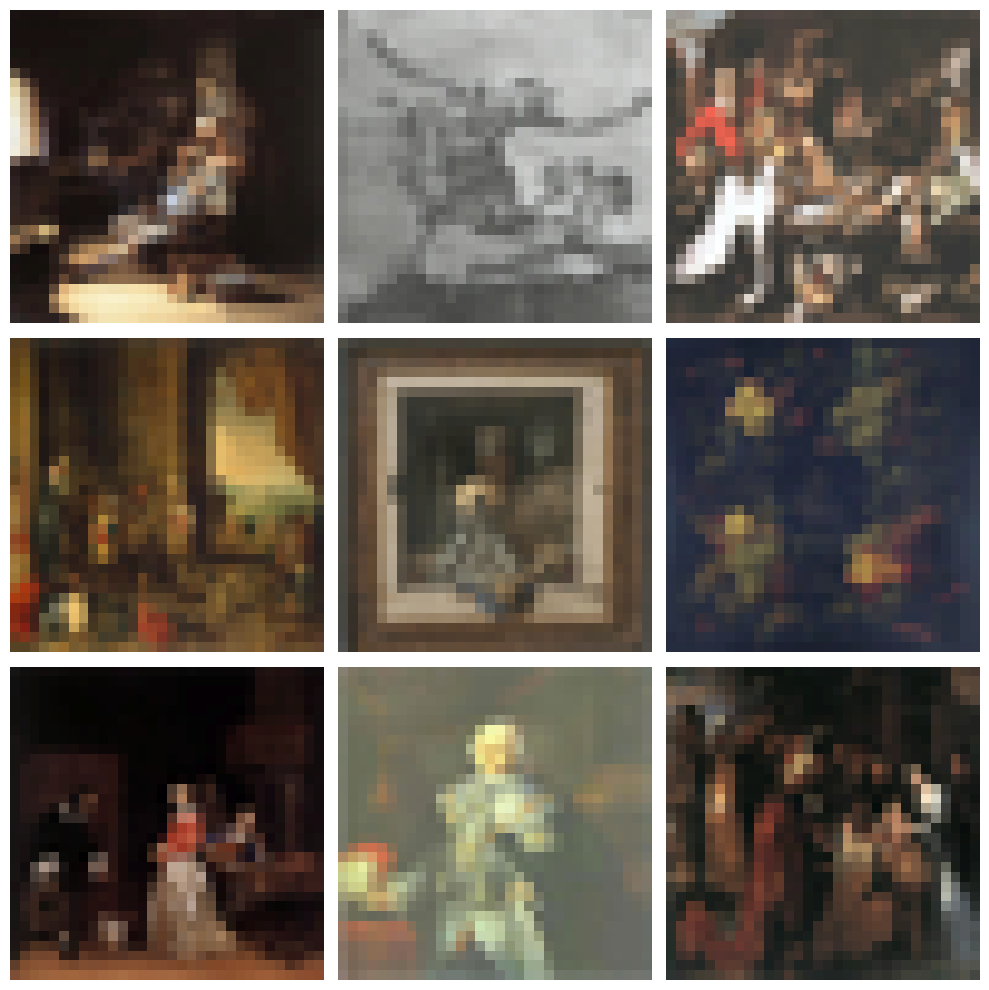

In [14]:
show_images(dataset_32, num_images=9)

[Back to the top](#start)
<a name='3.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: Diffusion Model from scratch</strong></h2>
</div>

In dit hoofdstuk gebruiken we de functies uit main.py om ons Diffusion Model from scratch op te zetten, voor te bereiden en te trainen. Hiermee laten we zien hoe de losse onderdelen samenkomen tot ons generatief diffusion model voor Baroque schilderijen data.

<a name='3.1'></a>
<h3>&sect;3.1: Aanmaken parameters Diffusion Model</h3>

# Tijdelijk! nog weghalen!
Moeten we dit hieronder neerzetten, dit staat ook in de main.py, of moet het daar weg?

De eerste stap is het instellen van de parameters voor het diffusieproces.

- De eerste parameter die we instellen is T, dit staat voor het aantal timesteps. T bepaalt in hoeveel stappen er geleidelijk ruis aan de afbeeldingen wordt toegevoegd tijdens het forward diffusion-proces.

- Vervolgens definiëren we beta. Beta geeft aan hoeveel ruis er per stap wordt toegevoegd. Hiervoor gebruiken we np.linspace(1e-4, 0.02, T), wat betekent dat we een reeks van T waarden genereren die gelijkmatig verdeeld zijn tussen 1e-4 en 0.02. Dit zorgt ervoor dat de hoeveelheid toegevoegde ruis langzaam toeneemt naarmate het proces vordert — met weinig ruis in het begin en steeds iets meer richting het einde.

- Hierna berekenen we alpha, dat wordt gedefinieerd als 1 - beta. Alpha representeert het deel van de originele afbeelding dat na elke stap behouden blijft (dus: hoe weinig ruis er is toegevoegd).

- Tot slot berekenen we alpha_bar, de cumulatieve productwaarde van alle voorgaande alpha-waarden. Alpha_bar geeft aan hoeveel van het oorspronkelijke signaal (de originele afbeelding) nog over is na een bepaald aantal timesteps. Naarmate t toeneemt, wordt deze waarde steeds kleiner dit betekent dat steeds meer ruis is en steeds minder overblijft van het originele beeld.


In [15]:
T = 250
beta = np.linspace(1e-4, 0.02, T)
alpha = 1 - beta
alpha_bar = np.cumprod(alpha)

<a name='3.2'></a>
<h3>&sect;3.2: Dataset klaarmaken voor training</h3>



De tweede stap is het klaarmaken van de afbeeldingsdata voor training.

- Met de eerste regel data = dataset_32.reshape(-1, 32x32x3) flattenen we de afbeeldingen van een 3D-vorm naar een 1D-vector. Omdat elke afbeelding 32 pixels hoog, 32 pixels breed en 3 kleurkanalen (RGB) heeft, wordt elke afbeelding omgezet naar een vector van lengte 3072. De -1 zorgt ervoor dat NumPy automatisch het aantal afbeeldingen invult.

- Vervolgens normaliseren we de waarden in de dataset met data = (data / 127.5) - 1.0. Normaal bevatten RGB-afbeeldingen waarden tussen 0 en 255. Door eerst te delen door 127.5 en daarna 1.0 af te trekken, brengen we deze waarden terug naar het bereik [-1, 1]. Dit doen we omdat modellen tijdens training beter convergeren wanneer de inputwaarden rondom nul liggen.

In [16]:
data = dataset_32.reshape(-1, 32*32*3)  # Flatten de afbeeldingen naar vectoren
data = (data / 127.5) - 1.0  # Normaliseer naar [-1,1]

<a name='3.3'></a>
<h3>&sect;3.3: Het model aanroepen</h3>

Nu in stap 3 maken we een nieuw Diffusion Model aan.

Hiervoor gebruiken we de functie DiffusionModel, waarbij we meerdere parameters kunnen instellen op basis van de dataset. Hieronder lichten we toe wat deze parameters betekenen:

  - input_dim=32*32*3: Dit is simpelweg de vorm van de afbeelding nadat deze is geflattened naar een 1D-vector.

  - t_embed_dim=16: Dit geeft aan hoeveel getallen we gebruiken om de tijdstap (t) om te zetten naar een vector die het model kan begrijpen. Hoe hoger deze waarde, hoe meer ruimte het model heeft om te leren van wanneer in het diffusieproces het zich bevindt. In dit geval gebruiken we 16 getallen om één tijdstap te representeren.

  -hidden_dims=[512, 1024, 512]: Dit bepaalt het aantal neuronen in de verborgen lagen van het neurale netwerk. In main.py is gekozen voor drie lagen, met respectievelijk 512, 1024 en 512 neuronen. Deze getallen bepalen hoe zwaar of licht het model is. Wij kunnen dit naar wens aanpassen om bijvoorbeeld sneller te trainen of betere resultaten te behalen.

  -output_dim=32x32x3: De outputdimensie is gelijk aan de input, omdat het model voorspelt hoeveel ruis er is toegevoegd aan elke pixel. We willen dus een outputvector van dezelfde grootte als de input.

In [20]:
model = DiffusionModel(input_dim=32*32*3, t_embed_dim=16, hidden_dims=[512, 1024, 512], output_dim=32*32*3)

<a name='3.4'></a>
<h3>&sect;3.4: Het model trainen</h3>

Aangekomen bij stap 4 gaan we het Diffusion Model daadwerkelijk trainen. Dit doen we met behulp van de functie train_diffusion_model().

We geven hierbij de volgende parameters mee:

  - model: het Diffusion Model dat we eerder hebben aangemaakt.

  - data: de genormaliseerde en geflattenede afbeeldingendata, in ons geval schilderijen in Barokstijl.

  - epochs=2: het aantal keer dat het model de volledige dataset doorloopt. Normaal zou dit bijvoorbeeld op 200 staan, maar voor testdoeleinden gebruiken we tijdelijk 2.

  - batch_size=16: het aantal afbeeldingen dat tegelijk wordt verwerkt in één trainingsstap. Hoe hoger de batch size, hoe sneller de training verloopt, maar des te meer rekenkracht er nodig is.

In deze stap leert het model te voorspellen welke ruis is toegevoegd aan de inputdata. Dit is onderdeel van het forward process. Hoe beter het model hierin wordt, hoe beter het later het reverse process kan uitvoeren, waarmee het stap voor stap ruis kan verwijderen en uiteindelijk nieuwe afbeeldingen kan genereren.


Na het aanroepen van de functie begint het model met trainen. Tijdens dit proces zien we een aantal statistieken in de console verschijnen:

- Epoch x/x geeft aan in welke fase van de training we zitten.

- De progressbar (██████████) laat zien hoeveel batches er al zijn verwerkt binnen de huidige epoch.

- Loss geeft aan hoe goed het model op dat moment presteert. Een lagere loss betekent dat het model beter is geworden in het voorspellen van de toegevoegde ruis. Volgens de paper is het ideal om tussen de 0.1 en 0.01 te scoren.

- Time toont hoe lang één epoch heeft geduurd.

- Average gradients laat de gemiddelde grootte van de gewichtsaanpassingen per laag zien. Dit geeft inzicht in hoe sterk het model op dat moment nog leert.


In [25]:
train_diffusion_model(model, data, epochs=2, batch_size=16) # Voorheen 200 epochs, voor de test 2

Starting Epoch 1/2


Epoch 1/2:   3%|▎         | 7/265 [00:02<01:16,  3.36it/s]


KeyboardInterrupt: 

[Back to the top](#start)
<a name='4.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: Vergelijken werkelijke data met gegenereerde data</strong></h2>
</div>

Na het trainen van het model is het tijd om te kijken naar de prestaties. We doen dit door een visuele vergelijking te maken tussen afbeeldingen uit de oorspronkelijke Baroque-dataset en afbeeldingen die door het model zijn gegenereerd.

- Met de functie sample() genereren we nieuwe afbeeldingen op basis van puur ruis, en met compare_generated_vs_real() zetten we deze naast een selectie van echte afbeeldingen.

- Op deze manier krijgen we een eerste indruk van hoe goed het model erin slaagt om de stijl en kenmerken van de trainingsdata na te bootsen. Het doel is niet om exacte kopieën te maken, maar om nieuwe afbeeldingen te creëren die qua stijl en opbouw overeenkomen met de originele Baroque kunst, echter is dit helaas in ons geval niet gelukt.

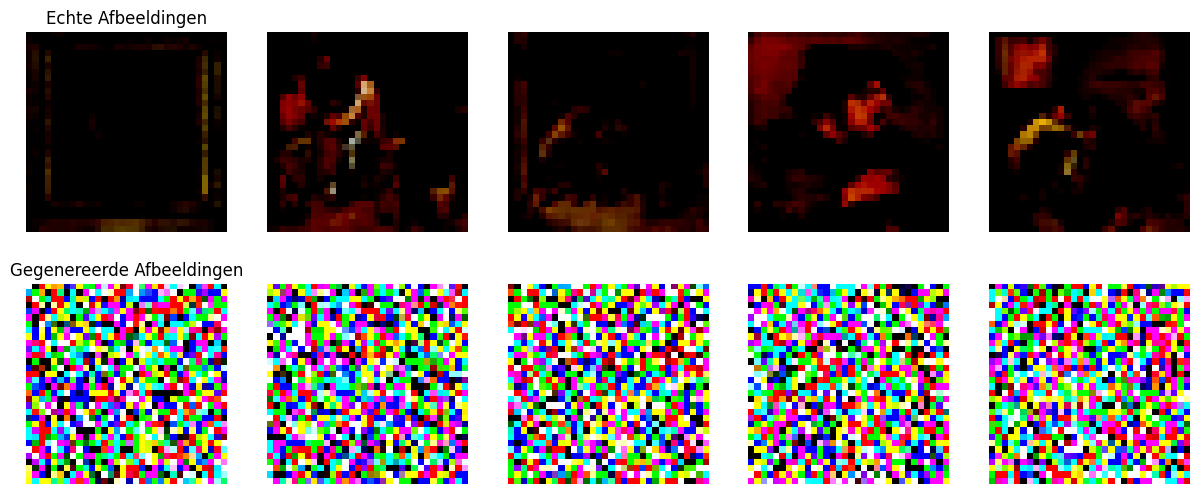

In [23]:
generated_samples = sample(model, shape=(5, 32, 32, 3))
compare_generated_vs_real(generated_samples, dataset_32[:5])

[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H5: Korte reflectie op resultaten</strong></h2>
</div>

Helaas is het ons (nog) niet gelukt om een afbeelding te genereren die visueel overeenkomt met de werkelijke data. In plaats daarvan genereert het model voornamelijk ruis. Mogelijke oorzaken hiervan zijn het beperkte aantal trainingsafbeeldingen, een te eenvoudig model (bijvoorbeeld te weinig lagen), of een tekort aan trainingsrondes (epochs).

Binnen de beschikbare tijd hebben we veel aanpassingen moeten doen aan de modelcode. Zo hebben we meer lagen toegevoegd, een andere activatiefunctie toegepast en het aantal epochs verhoogd. Een grote uitdaging was het gebrek aan een computer met GPU. Hierdoor werd het trainen van het model erg tijdrovend — één epoch duurde soms wel drie uur — wat het lastig maakte om uitgebreid te experimenteren met verbeteringen.

Wel zijn we erin geslaagd om een trainingsronde te draaien waarbij de loss bleef dalen, maar uiteindelijk stabiliseerde rond een waarde van 0.86. Voor een goed werkend diffusion model zou de loss idealiter tussen de 0.1 en 0.01 moeten liggen. Dit niveau hebben we binnen onze testopstelling helaas niet weten te bereiken.

[Back to the top](#start)
<a name='6.0'></a>

<div style="background-color:#216375; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H6: Literatuurlijst</strong></h2>
</div>

- [Chat GPT voor verbeteren van diffusion](https://chatgpt.com/c/67d9c8f9-6410-8000-94a6-6dc0743076da)
- [Git met Diffusion Model](https://github.com/dome272/Diffusion-Models-pytorch/blob/main/ddpm.py)